In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Dense, Masking, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error

In [14]:

# Define the paths to your data directories
# Define the paths to your data directories
data_directory_matrices = r'C:\Users\Xande\OneDrive\Documents\Masters Project\Simulated Data\data\imputed_data_proportional_change'
data_directory_labels = r'C:\Users\Xande\OneDrive\Documents\Masters Project\Simulated Data\data\imputed_data_proportional_change\mean_imputation'  # Update this to the correct subdirectory for labels


# Function to load data matrices
def load_data_matrices(directory):
    data = {}
    for filename in os.listdir(directory):
        if filename.startswith('data_matrix_'):
            id = filename.split('_')[2].split('.')[0]
            data[id] = pd.read_csv(os.path.join(directory, filename)).values
    return data

# Function to load labels
def load_labels(directory):
    labels = {}
    for filename in os.listdir(directory):
        if filename.startswith('label_'):
            id = filename.split('_')[1].split('.')[0]
            label_df = pd.read_csv(os.path.join(directory, filename))
            if label_df.shape[0] > 0:
                labels[id] = label_df.iloc[0, 0]  # Read the label from the first row, first column
            else:
                print(f"Error reading label for {id}. File content:")
                print(label_df)
    return labels

# Load the data matrices and proportional change labels
data_matrices = load_data_matrices(data_directory_matrices)
proportional_change_labels = load_labels(data_directory_labels)

# Convert labels to numpy array
labels_list = [proportional_change_labels[id] for id in sorted(proportional_change_labels.keys())]
labels_array = np.array(labels_list)

print("Data shape:", {id: matrix.shape for id, matrix in data_matrices.items()})
print("Labels shape:", labels_array.shape)


Data shape: {'2147483663': (3, 18), '2147483759': (3, 18), '2147483915': (3, 19), '2147483938': (3, 13), '2147484212': (3, 11), '2147484364': (3, 17), '2147484918': (3, 18), '2147485102': (3, 18), '2147485580': (3, 14), '2147487150': (3, 12), '2147487760': (3, 13), '2147488023': (3, 19), '2147488302': (3, 13), '2147488497': (3, 18), '2147489508': (3, 18), '2147492246': (3, 11), '2147496199': (3, 17), '2147499971': (3, 18), '2147501140': (3, 13), '2147501224': (3, 15), '2147501568': (3, 18), '2147502548': (3, 18), '2147502799': (3, 8), '2147503770': (3, 8), '2147504717': (3, 19), '2147505624': (3, 18), '2147506242': (3, 14), '2147507644': (3, 18), '2147507667': (3, 19), '2147508745': (3, 18), '2147510703': (3, 13), '2147516727': (3, 14), '2147518302': (3, 19), '2147518515': (3, 18), '2147520727': (3, 19), '2147522389': (3, 19), '2147523529': (3, 18), '2147524446': (3, 19), '2147526347': (3, 12), '2147526869': (3, 19), '2147528765': (3, 19), '2147529604': (3, 19), '2147529990': (3, 19), 

In [15]:
# Function to pad each individual's matrix to the maximum number of columns
def pad_matrix(matrix, max_cols):
    padding_width = max_cols - matrix.shape[1]
    if (padding_width > 0):
        return np.pad(matrix, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)
    return matrix

# Pad the sequences data
max_cols = max(matrix.shape[1] for matrix in data_matrices.values())
padded_data_matrices = {id: pad_matrix(matrix, max_cols) for id, matrix in data_matrices.items()}

# Convert to numpy arrays
data_array = np.array([padded_data_matrices[id] for id in sorted(padded_data_matrices.keys())])
labels_array = np.array([proportional_change_labels[id] for id in sorted(proportional_change_labels.keys())])

print("Padded Data shape:", data_array.shape)
print("Labels shape:", labels_array.shape)


Padded Data shape: (5163, 3, 19)
Labels shape: (5163,)


## GRU MODEL

In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_array, labels_array, test_size=0.2, random_state=42)

# Define input shape
input_shape = (max_cols, data_array.shape[2])  # Assuming data is (samples, timesteps, features)

# Define Enhanced GRU Model with Dropout
def build_enhanced_gru_model(input_shape):
    model = Sequential([
        GRU(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        GRU(100),
        Dropout(0.3),
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['mae'])
    return model

# Build and summarize the model
enhanced_model = build_enhanced_gru_model(input_shape)
enhanced_model.summary()

# Train the enhanced model
history = enhanced_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the enhanced model
loss, mae = enhanced_model.evaluate(X_test, y_test)
print(f"Enhanced Model Test Loss: {loss}")
print(f"Enhanced Model Test MAE: {mae}")

# Generate predictions and calculate additional metrics
y_pred = enhanced_model.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

print(f"Enhanced Model MSE: {mse}, MAE: {mae}, R2: {r2}")


c:\Users\Xande\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 19, 100)        │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 19, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,101 (418.36 KB)

 Trainable params: 107,101 (418.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 384.2311 - mae: 13.3339 - val_loss: 366.8601 - val_mae: 13.6746
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 420.9116 - mae: 13.6518 - val_loss: 366.1462 - val_mae: 13.6458
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 441.4615 - mae: 13.8055 - val_loss: 367.3659 - val_mae: 13.6600
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 448.4712 - mae: 13.7674 - val_loss: 366.7845 - val_mae: 13.6917
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 382.1665 - mae: 13.1250 - val_loss: 366.5114 - val_mae: 13.6545
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 372.0074 - mae: 13.2035 - val_loss: 374.2736 - val_mae: 13.8697
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 411.4365 - mae: 13.7140 - val_loss: 368.6248 - val_mae: 13.7231
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 386.1782 - mae: 13.1312 - val_loss: 368.6199 - val_mae: 13.7567
Epoch 9/

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


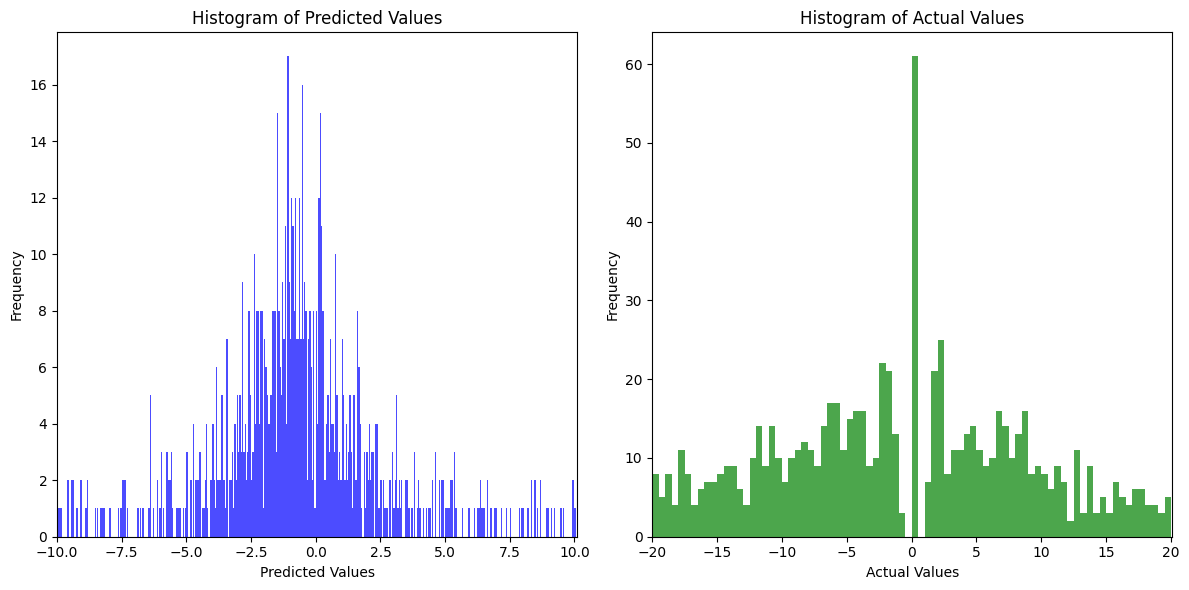

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = enhanced_model.predict(X_test).flatten()

# Plot histogram of the predicted values with specified bin size and range
plt.figure(figsize=(12, 6))

# Histogram of predicted values
plt.subplot(1, 2, 1)
plt.hist(y_pred, bins=np.arange(-10, 10.1, 0.05), color='blue', alpha=0.7)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Values')
plt.xlim(-10, 10.1)

# Histogram of actual values
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=np.arange(-20, 20.1, 0.5), color='green', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Values')
plt.xlim(-20, 20.1)

plt.tight_layout()
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\Xande\AppData\Local\Temp\ipykernel_27604\3845029240.py:11: RuntimeWarning: divide by zero encountered in divide
  percentage_errors = (errors / y_test) * 100


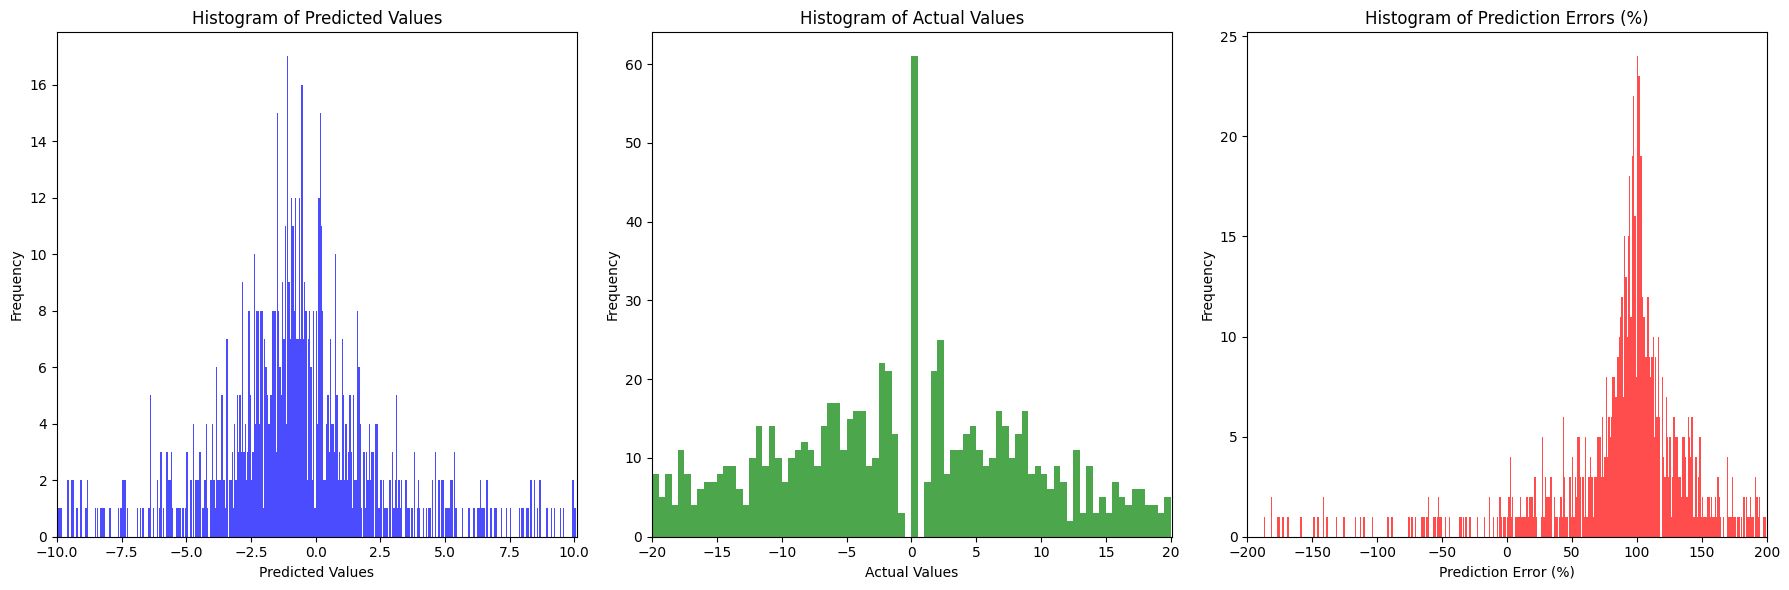

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = enhanced_model.predict(X_test).flatten()

# Calculate prediction errors
errors = y_test - y_pred

# Calculate percentage errors
percentage_errors = (errors / y_test) * 100

# Plot histograms
plt.figure(figsize=(18, 6))

# Histogram of predicted values
plt.subplot(1, 3, 1)
plt.hist(y_pred, bins=np.arange(-10, 10.1, 0.05), color='blue', alpha=0.7)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Values')
plt.xlim(-10, 10.1)

# Histogram of actual values
plt.subplot(1, 3, 2)
plt.hist(y_test, bins=np.arange(-20, 20.1, 0.5), color='green', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Frequency')
plt.title('Histogram of Actual Values')
plt.xlim(-20, 20.1)

# Histogram of percentage prediction errors
plt.subplot(1, 3, 3)
plt.hist(percentage_errors, bins=np.arange(-200, 200.1, 1), color='red', alpha=0.7)
plt.xlabel('Prediction Error (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors (%)')
plt.xlim(-200, 200.1)

plt.tight_layout()
plt.show()



## LSTM

In [9]:
from tensorflow.keras.layers import LSTM

# Define the LSTM model as an alternative approach
def build_lstm_model(input_shape, lstm_units, dense_units, learning_rate):
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        LSTM(lstm_units),
        Dense(dense_units, activation='relu'),
        Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Parameters
LSTM_UNITS = 100

# Build and compile the LSTM model
lstm_model = build_lstm_model(input_shape, LSTM_UNITS, DENSE_UNITS, LEARNING_RATE)

# Summary of the model
lstm_model.summary()

# Train the LSTM model
history = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

# Evaluate the LSTM model
y_pred_lstm = lstm_model.predict(X_test).flatten()
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f'MSE: {mse_lstm}, MAE: {mae_lstm}, R2: {r2_lstm}')


NameError: name 'DENSE_UNITS' is not defined

## Random Forest

MSE: 42595.70860644042, MAE: 10.942999480721816, R2: -0.006891484418892979


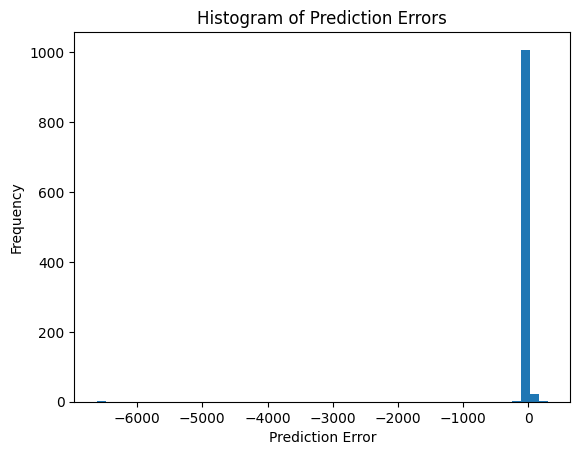

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Flatten the 3D data array for the Random Forest model
num_samples, num_timesteps, num_features = data_array.shape
X = data_array.reshape(num_samples, num_timesteps * num_features)
y = labels_array

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')

# Plot histogram of prediction errors
errors = y_test - y_pred
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

In [12]:
# Assuming labels_array contains your actual labels
actual_values = labels_array

# Calculate the average of actual values (or you can use median)
average_actual_value = np.mean(actual_values)

# Calculate the percentage error
percentage_error = (mae / average_actual_value) * 100

print(f'Average Percentage Error: {percentage_error:.2f}%')

Average Percentage Error: -722.52%
